<h1> Stéganographie par LSB </h1>
<i>par Claudia Delgado et Mehdi Miah - Mars 2017</i>

# Plan 

# Import

In [1]:
from scipy import misc
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

%matplotlib inline

# Choices of images

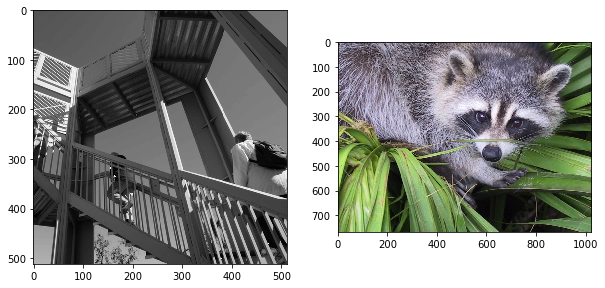

In [2]:
original_carrier = misc.ascent()
original_hidden = misc.face()

plt.figure(figsize = (10,10))
plt.subplot(1, 2, 1)
plt.imshow(original_carrier, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(original_hidden)

# Cleaning the images

In [3]:
# Shapes of images
print('The carrier image is', original_carrier.shape)
print('The hidden image is', original_hidden.shape)

The carrier image is (512, 512)
The hidden image is (768, 1024, 3)


In [4]:
# Test if the two inputs have the same size
if original_carrier.shape == original_hidden.shape:
    print('OK, the two inputs have the same dimensions.')
else:
    print('BEWARE, you have to trunc an image.')
    
# Optimal size    
x_min = min(original_carrier.shape[0], original_hidden.shape[0])
y_min = min(original_carrier.shape[1], original_hidden.shape[1])

print('The best dimension size is %.f x %.f.' %(x_min , y_min))

BEWARE, you have to trunc an image.
The best dimension size is 512 x 512.


In [5]:
#Correction of the hidden image (ALAMANO)
hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
hidden = hidden[:,:,0]
carrier = original_carrier

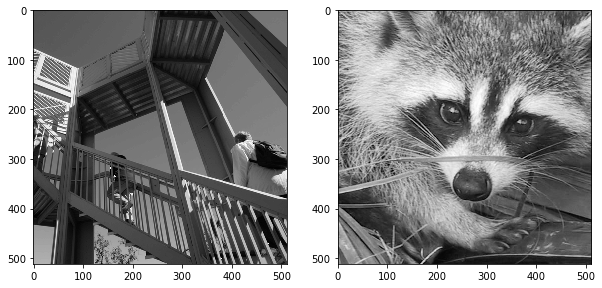

In [6]:
#Cleaned images (same dimensions)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(carrier, cmap=plt.cm.gray)#, interpolation="none")
plt.subplot(1,2,2)
plt.imshow(hidden, cmap=plt.cm.gray)#, interpolation="none")

In [7]:
#Sanity check
print(carrier.shape == hidden.shape)

True


# Functions to code and decode

In [8]:
def code_steganography_lsb(carrier, hidden, nb_hidden_bit=1):
    '''
    Input : carrier - number between 0 and 255 corresponding to the bit code of the carrier image
          : hidden - number between 0 and 255 corresponding to the bit code of the hidden image
          : nb_hidden_bit - the number of hidden bits
    Output : output - image resulting from the code      
    '''
    #check that the number is an integer between 1 and 7 included
    assert nb_hidden_bit in range(1,8), "nb_hidden_bit should be between 1 and 7"

    #Binary of the carrier
    bin_carrier = format(carrier,'08b')

    #Binary of the hidden
    bin_hidden = format(hidden,'08b')

    #Result of the LSB algorithm
    bin_output = bin_carrier[:-nb_hidden_bit] + bin_hidden[:nb_hidden_bit-8]
    output = int(bin_output, 2)

    return output

In [102]:
def decode_steganography_lsb(output, nb_hidden_bit=1):
    '''
    Input : output - number between 0 and 255 corresponding to the bit code of the output image
          : nb_hidden_bit - the number of hidden bits
    '''
    #check that the number is an integer between 1 and 7 included
    assert nb_hidden_bit in range(1,8), "nb_hidden_bit should be between 1 and 7"

    #Binary of the output
    bin_output = format(output,'08b')

    #Decode the binary code
    #for the carrier
    bin_carrier = bin_output[:8-nb_hidden_bit] + '0'*nb_hidden_bit
    carrier = int(bin_carrier , 2)

    #for the hidden
    bin_hidden = bin_output[-nb_hidden_bit:] + '0'*(8-nb_hidden_bit)
    hidden = int(bin_hidden , 2)

    return carrier, hidden

In [103]:
decode_steganography_lsb(89, nb_hidden_bit=1)

(88, 128)

In [104]:
def msb(image, nb_bits = 3):
    bin_image = format(image,'08b')
    bin_output = bin_image[:nb_bits] + '0'*(8-nb_bits)
    output = int(bin_output, 2)
    
    print(bin_image, bin_output, output)
    
    return(output)

In [105]:
msb(100, nb_bits = 1)

01100100 00000000 0


0

# Application

In [115]:
%%time
#Encode
nb_hidden_bits_encode = 1
output = carrier.copy()
for i in range(carrier.shape[0]):
    for j in range(carrier.shape[1]):
        output[i,j] = code_steganography_lsb(carrier[i,j], hidden[i,j], nb_hidden_bits_encode)

Wall time: 1.34 s


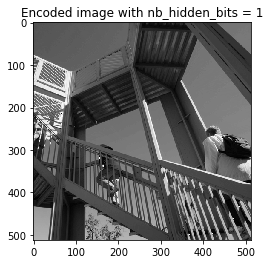

In [116]:
plt.imshow(output, cmap=plt.cm.gray)
plt.title('Encoded image with nb_hidden_bits = %.0f' %nb_hidden_bits_encode)

In [119]:
%%time
#Decode
nb_hidden_bits_decode = 2
carrier_decode = output.copy()
hidden_decode = output.copy()
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        carrier_decode[i,j], hidden_decode[i,j] = decode_steganography_lsb(output[i,j], nb_hidden_bits_decode)

Wall time: 1.3 s


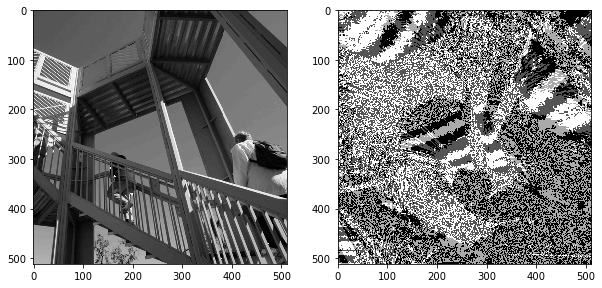

In [120]:
#Decodes images 
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(carrier_decode, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(hidden_decode, cmap=plt.cm.gray)

# Multi application

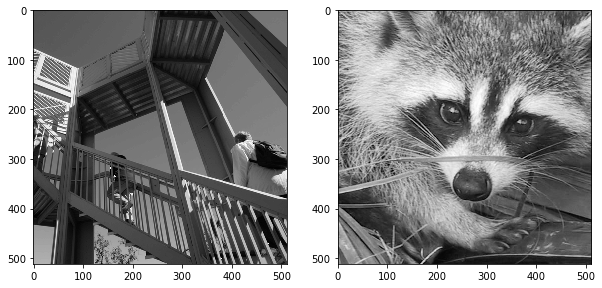

In [114]:
#Original images
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(carrier, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(hidden, cmap=plt.cm.gray)

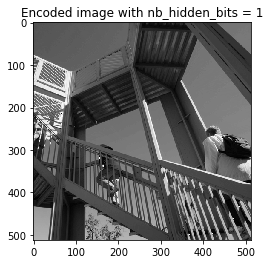

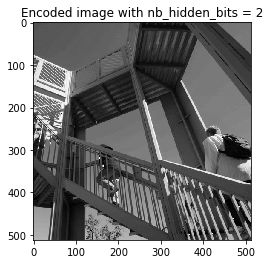

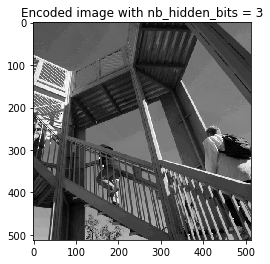

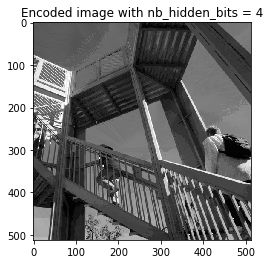

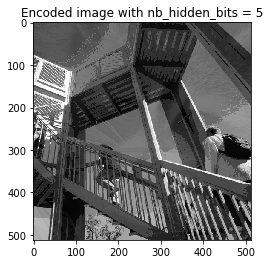

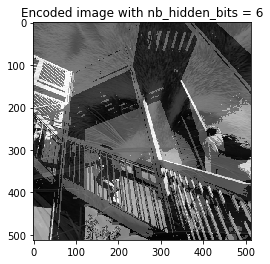

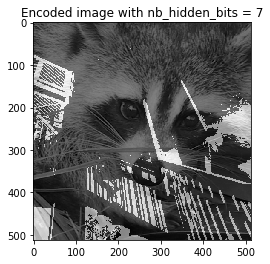

In [49]:
#Encodes images
all_output = []
for nb_hidden_bits_encode in range(1,8):
    output = carrier.copy()
    for i in range(carrier.shape[0]):
        for j in range(carrier.shape[1]):
            output[i,j] = code_steganography_lsb(carrier[i,j], hidden[i,j], nb_hidden_bits_encode)
    all_output.append(output)        
    plt.imshow(output, cmap=plt.cm.gray)
    plt.title('Encoded image with nb_hidden_bits = %.0f' %nb_hidden_bits_encode)
    plt.show()